In [3]:
import boto3
import numpy as np
import pandas as pd
from sagemaker import get_execution_role


role = get_execution_role()
bucket='hack4med'

przyjecie_file = 'CRACoV-PRZYJECIE.csv'
biochemia_file = 'CRACoV-BIOCHEMIA_3.csv'
echo_file = 'CRACoV-ECHO.csv'
nefro_file = '_CRACoV-NEFRO.csv'
mapowanie_tomografii_file = 'CRACoV-MAPOWANIE-TOMOGRAFII.csv'
radio_file = 'CRACoV-RADIO.csv'
etykiety_file = 'CRACoV-ETYKIETY.csv'

def load_csv(file, skiprows=0):
    data_location = 's3://{}/{}'.format(bucket, file)
    return pd.read_csv(data_location, skiprows=skiprows)

# tutaj mamy wszystkie wczytane dane
przyjecia = load_csv(przyjecie_file)
biochemia = load_csv(biochemia_file)
echo = load_csv(echo_file)
# nefro ma zwalony pierwszy wiersz
nefro = load_csv(nefro_file, 1)
mapowanie_tomografii = load_csv(mapowanie_tomografii_file)
radio = load_csv(radio_file)
etykiety = load_csv(etykiety_file)

def clean_data(df):
    df = df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
    
    df = df.replace('nie', 0)
    df = df.replace('nie wiadomo', 1)
    df = df.replace('tak', 2)
    
    df = df.replace('covid', 1)
    df = df.replace('inny (współistniejący covid)', 1)
    
    df = df.fillna(0)
    return df

def lpAndidLabToInt(df):
    return df.astype({"LP.": int, "ID_LAB": int})

def createId(df):
    df["ID"] = df["LP."] + 100000*df["ID_LAB"]
    df = df.astype({"ID": int})
    df.drop('LP.', inplace=True, axis=1)
    df.drop('ID_LAB', inplace=True, axis=1)
    return df

def load_and_parse(file):
    df = load_csv(file)
    df = clean_data(df)
    df = lpAndidLabToInt(df)
    df = createId(df)
    return df





def load_przyjecia():
    df = load_and_parse(przyjecie_file)
    df = df.astype({"WIEK": int, "PRZENIESIENIE": int, "HOSP_PRZYCZ": int, "NT": int, "DM": int, "ASTMA": int, "POCHP": int, "HF": int, "AF": int, "UDAR": int, "CHD": int, "MI": int, "ZAP_PLUC": int, "PCHN": int, "DEKSAMETEZON": int, "HDCZ": int, "BB": int, "STATYNA": int, "ASA": int, "NOAC": int, "MRA": int, "ACE": int, "SARTANY": int, "CA_BLOKER": int})
    df = df.filter(items=['ID', 'PLEC', 'WIEK', 'WZROST', 'PRZENIESIENIE', 'HOSP_PRZYCZ', 'MASA_CIALA', 'BMI', 'RRS', 'RRD', 'PO2_ATM', 'ODDECH', 'AS', 'NT', 'DM', 'ASTMA', 'POCHP', 'HF', 'AF', 'UDAR', 'CHD', 'MI', 'ZAP_PLUC', 'PCHN', 'DEKSAMETEZON', 'HDCZ', 'BB', 'STATYNA', 'ASA', 'NOAC', 'MRA', 'ACE', 'SARTANY', 'CA_BLOKER'])
    return df

def load_biochemia():    
    df = load_and_parse(biochemia_file)
    df = df.filter(items=['ID', 'KOD', 'WYNIK'])
    df = df.drop_duplicates(subset=['ID', 'KOD'], keep='last')
    df = df.pivot(index="ID", columns="KOD", values="WYNIK")
    df = df.applymap(lambda x: x.replace('<', '') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.replace('>', '') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.replace(' mg/l', '') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df


def load_echo():
    df = load_and_parse(echo_file)
    return df

# def load_nefro():
#     return load_csv(nefro_file, 1)

def load_mapowanie_tomografii():
    df = load_and_parse(mapowanie_tomografii_file)
    return df


def load_radio():
    df = load_and_parse(radio_file)
    return df


def load_etykiety():
    df = load_and_parse(etykiety_file)
    return df



def all_data():
    joined = pd.merge(load_przyjecia(), load_biochemia(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_echo(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_mapowanie_tomografii(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_radio(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_etykiety(), on=["ID"], how='outer')
    joined = joined.fillna(0)
    return joined

data = all_data()

data

,ID,PLEC,WIEK,WZROST,PRZENIESIENIE,HOSP_PRZYCZ,MASA_CIALA,BMI,RRS,RRD,...,Volume of ground glass in both lungs (cm3),Consolidation volume of both lungs (cm3),Proportion of lung lesions (%),Proportion of ground glass in both lungs (%),Consolidation of both lungs accounted for (%),Pneumonia grade,ZGON_SZPITALNY,PROGRESJA,OIT,ZGON_LUB_OIT
0,1,0,84,178.0,2,1,65.0,20.51,98.0,57.0,...,0.00,0.00,0.00,0.00,0.00,0,1,1,0,1
1,2,0,83,170.0,0,1,75.0,25.95,122.0,75.0,...,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0
2,5,0,78,178.0,0,1,90.0,28.40,119.0,65.0,...,1064.70,158.17,24.54,21.56,3.20,critical,1,0,1,1
3,3,0,76,178.0,0,1,75.0,23.67,145.0,90.0,...,0.00,0.00,0.00,0.00,0.00,0,1,0,0,1
4,10,1,72,163.0,0,1,77.0,28.98,131.0,98.0,...,1889.63,660.23,67.30,50.35,17.59,critical,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,49000496,1,65,168.0,0,1,102.0,36.13,150.0,84.0,...,439.32,62.66,9.02,7.97,1.14,moderate,0,0,0,0
496,49100497,0,77,171.0,0,1,86.0,29.41,149.0,91.0,...,1820.57,207.83,42.02,38.05,4.34,critical,0,0,1,1
497,49200498,0,58,0.0,0,0,0.0,0.00,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0
498,49300499,1,66,167.0,0,1,93.2,33.41,130.0,85.0,...,0.00,0.00,0.00,0.00,0.00,0,0,0,1,1


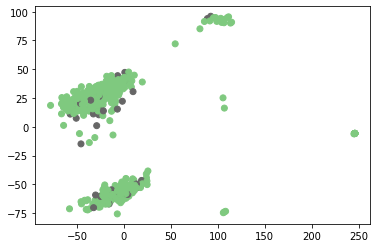

In [128]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import StandardScaler

cols = ['PLEC', 'WIEK', 'WZROST', 'PRZENIESIENIE', 'MASA_CIALA', 'BMI', 'RRS', 'RRD', 'PO2_ATM', 'ODDECH', 'AS', 'NT', 'DM', 'ASTMA', 'HF', 'AF', 'UDAR', 'CHD', 'MI', 'ZAP_PLUC',  'HDCZ', 'BB', 'STATYNA', 'ASA', 'NOAC', 'MRA', 'ACE', 'SARTANY', 'CA_BLOKER', 'ZGON_LUB_OIT']
data = data.filter(cols)

df_normalized=(data - data.mean()) / data.std()


pca = PCA(n_components=2)
# pca = PCA(data.shape[1])
# pca = PCA(n_components=3)

projected = pca.fit_transform(data)
# projected = pca.fit_transform(df_normalized)



plt.scatter(projected[:, 0], projected[:, 1],
            cmap=plt.cm.get_cmap('Accent', 2),
            c=data['ZGON_LUB_OIT'])



# pca = PCA(n_components=data.shape[1])
# pca.fit(df_normalized)

# loadings = pd.DataFrame(pca.components_.T,
# columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
# index=data.columns)

# plt.plot(pca.explained_variance_ratio_)
# plt.ylabel('Explained Variance')
# plt.xlabel('Components')
# plt.show()



# fig = px.scatter_3d(
#     projected, x=0, y=1, z=2, color=data['ZGON_LUB_OIT']
# )
# fig.show()



# map= pd.DataFrame(pca.components_,columns=cols)
# plt.figure(figsize=(12,6))
# sns.heatmap(map,cmap='twilight')
